<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h2>Deep Non-Crossing Quantiles through the Partial Derivative </h2></div>

Code is made available under the [Apache Version 2.0 License](https://www.apache.org/licenses/LICENSE-2.0). 

> Copyright 2022
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>    http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.


This source code corresponds to an official implementation of the following paper's contribution: 

[***Axel Brando, Joan Gimeno, Jose A. Rodriguez-Serrano, Jordi Vitria. "Deep Non-Crossing Quantiles through the Partial Derivative." International Conference on Artificial Intelligence and Statistics (AISTATS). 2022.***](https://arxiv.org/abs/2201.12848)

```
Quantile Regression (QR) provides a way to approximate a single conditional quantile. To have a more informative description of the conditional distribution, QR can be merged with deep learning techniques to simultaneously estimate multiple quantiles. However, the minimisation of the QR-loss function does not guarantee non-crossing quantiles, which affects the validity of such predictions and introduces a critical issue in certain scenarios. In this article, we propose a generic deep learning algorithm for predicting an arbitrary number of quantiles that ensures the quantile monotonicity constraint up to the machine precision and maintains its modelling performance with respect to alternative models. The presented method is evaluated over several real-world datasets obtaining state-of-the-art results as well as showing that it scales to large-size data sets. 
```

Please, to use this material and the code follow the instructions explained in the main repository [LINK](https://github.com/axelbrando/ChebyshevNetwork).

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>Main model definition ($Ours-q_0$)</h3></div>

Following we present how the $q_0$ version of the model can be generically loaded.

In [1]:
#If you are using GPU uncomment the following lines starting with '##'

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'

import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
from tensorflow.keras import backend as K
general_type = 'float64'
K.set_floatx(general_type)
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from Model import Model
from Model import qr
from Model import evaluate_qr
from Utils import load_synth_data

In [2]:
x_train_synthetic, y_train_synthetic, x_valid_synthetic, y_valid_synthetic, x_test_synthetic, y_test_synthetic = load_synth_data(general_type)

In [12]:
model = Model(degree=10, K='q0', arch=[300,300,300], K_arch=[300,300,300])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss=(lambda y, p: qr(y, p, n_taus=model.n_taus)))

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>Main model training</h3></div>

Following we present how the $q_0$ version of the model can be generically trained.

Epoch 1/10000
10/10 [==============================] - 0s 41ms/step - loss: 0.1527 - val_loss: 0.1437
Epoch 2/10000
10/10 [==============================] - 0s 20ms/step - loss: 0.1387 - val_loss: 0.1321
Epoch 3/10000
10/10 [==============================] - 0s 19ms/step - loss: 0.1325 - val_loss: 0.1311
Epoch 4/10000
10/10 [==============================] - 0s 19ms/step - loss: 0.1311 - val_loss: 0.1300
Epoch 5/10000
10/10 [==============================] - 0s 19ms/step - loss: 0.1303 - val_loss: 0.1295
Epoch 6/10000
10/10 [==============================] - 0s 19ms/step - loss: 0.1296 - val_loss: 0.1288
Epoch 7/10000
10/10 [==============================] - 0s 19ms/step - loss: 0.1291 - val_loss: 0.1284
Epoch 8/10000
10/10 [==============================] - 0s 19ms/step - loss: 0.1288 - val_loss: 0.1277
Epoch 9/10000
10/10 [==============================] - 0s 19ms/step - loss: 0.1287 - val_loss: 0.1278
Epoch 10/10000
10/10 [==============================] - 0s 19ms/step - loss: 0.128

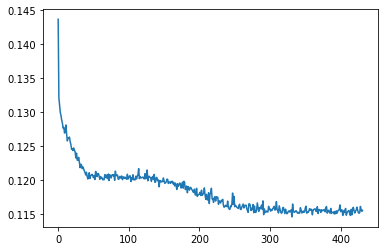

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=100,
                                      verbose=1,
                                      mode='auto',
                                      restore_best_weights=True)

history = model.fit(x_train_synthetic,
                        y_train_synthetic,
                        shuffle=True,
                        epochs=10000,
                        batch_size=1000,
                        verbose=1,
                        validation_data=(x_valid_synthetic, y_valid_synthetic),
                        callbacks=[es])
plt.plot(history.history['val_loss'])

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>Forecast non-crossing conditional quantiles</h3></div>

Following we present how the root quantiles can be forecasted and visualized.

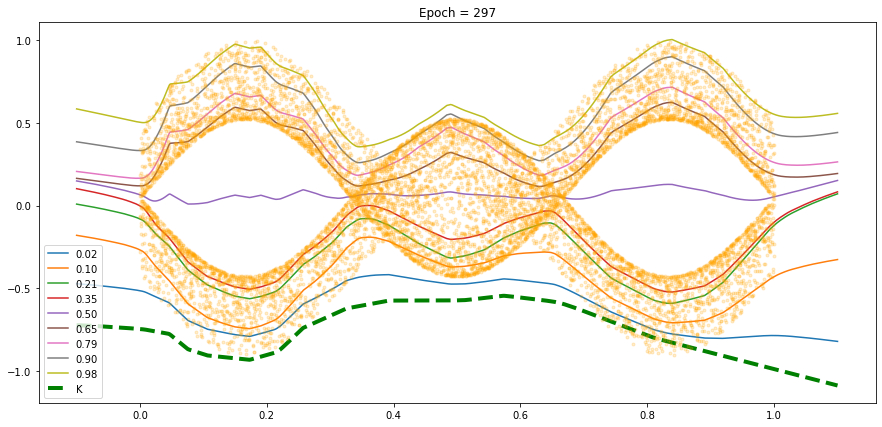

In [7]:
points = np.linspace(-0.1,1.1,num=1000).reshape(-1,1).astype(general_type)
sel_taus = np.array([(np.cos(np.pi*(k)/model.degree)+1.)/2. for k in range(1,model.degree)]).reshape(-1,1).astype(general_type)

qs = model.forecast(points,sel_taus)
qs = qs.numpy()[:,0].reshape(points.shape[0],-1)

plt.figure(figsize=(15,7))
for i in range(sel_taus.shape[0]-1,-1,-1):
    plt.plot(points[:,0],qs[:,i],label="%.2f"%(sel_taus[i][0]))

beta = model.K_output.numpy()

plt.plot(points[:,0],beta,'--',color='g',linewidth=4,label='K')

plt.legend()

plt.plot(x_train_synthetic,y_train_synthetic,'.',c='orange',alpha=0.2)
plt.title('Epoch = '+str(len(history.history['val_loss'])-100))
plt.show()

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>Checking the model performance</h3></div>

Following we present how the QR performance can be checked.

In [10]:
sel_taus = np.array([(np.cos(np.pi*(k+0.5)/model.degree)+1.)/2. for k in range(model.degree-1)]).reshape(-1,1).astype(general_type)
print("QR Mean and std performance in the test set:") 
pred = model.forecast(x_test_synthetic,sel_taus)
res = evaluate_qr(y_test_synthetic, pred, n_taus=sel_taus.shape[0])
print("\t %.3f ± %.3f"%(tf.keras.backend.mean(res).numpy(), tf.keras.backend.std(res).numpy()))

QR Mean and std performance in the test set:
	 0.849 ± 0.446


<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>Emphirical prove that the model avoids the Crossing Quantile Phenomenon</h3></div>

Following we present how the theoretically proved property of avoiding the crossing quantile phenomenon is emphirical tested.

In [11]:
def check_crossings_number(data):
    return (np.diff(data)>0).sum() > 0

data = pred.numpy()[:,0].reshape(x_test_synthetic.shape[0],-1)
print("Do it has any crossing? ",check_crossings_number(data))

Do it has any crossing?  False


<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>Increasing the number of roots but mantaining the non-crossing property</h3></div>

Following we present how the degree number can be increased while preserving the non-crossing of predicted quantiles property.

In [20]:
model = Model(degree=1000, K='q0')
model(x_train_synthetic[:1]);

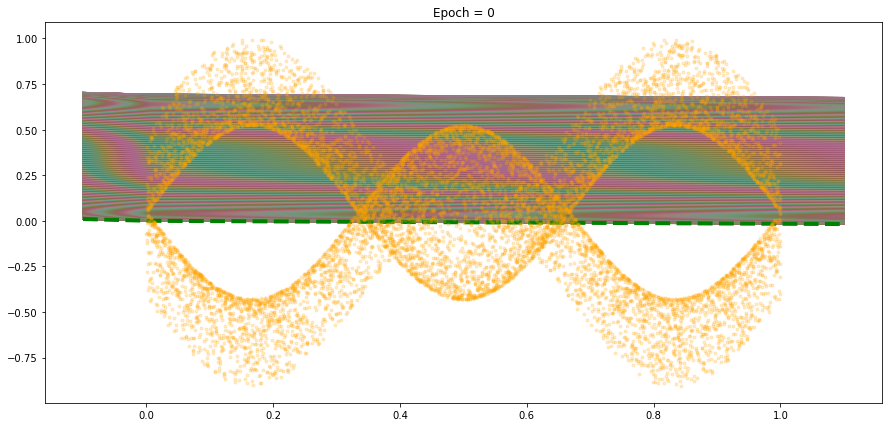

In [21]:
points = np.linspace(-0.1,1.1,num=1000).reshape(-1,1).astype(general_type)
#sel_taus = np.array([(np.cos(np.pi*(k+0.5)/model.degree)+1.)/2. for k in range(1,model.degree-1)]).reshape(-1,1).astype(general_type)

sel_taus = np.array([(np.cos(np.pi*(k)/model.degree)+1.)/2. for k in range(1,model.degree-1)]).reshape(-1,1).astype(general_type)

qs = model.forecast(points,sel_taus)
qs = qs.numpy()[:,0].reshape(points.shape[0],-1)

plt.figure(figsize=(15,7))
for i in range(sel_taus.shape[0]-1,-1,-1):
    plt.plot(points[:,0],qs[:,i])

beta = model.K_output.numpy()

plt.plot(points[:,0],beta,'--',color='g',linewidth=4)

plt.plot(x_train_synthetic,y_train_synthetic,'.',c='orange',alpha=0.2)
plt.title('Epoch = '+str(0))
plt.show()

In [22]:
print("QR Mean and std performance in the test set:") 
pred = model.forecast(x_test_synthetic,sel_taus)
res = evaluate_qr(y_test_synthetic, pred, n_taus=sel_taus.shape[0])
print("\t %.3f ± %.3f"%(tf.keras.backend.mean(res).numpy(), tf.keras.backend.std(res).numpy()))

QR Mean and std performance in the test set:
	 150.610 ± 127.851


In [23]:
def check_crossings_number(data):
    return (np.diff(data)>0).sum() > 0

data = pred.numpy()[:,0].reshape(x_test_synthetic.shape[0],-1)
print("Do it has any crossing? ",check_crossings_number(data))

Do it has any crossing?  False
